# CNN Classifier Analysis and Results
To measure the performance, we will evaluate the accuracy, the memory consumption, and finally, we will get the time of inference for each one of the models by testing the model with a random image from any other source e.g. internet, other datasets, etc.

# Common code for all trainers
In the case you need to restart the Jupyter Kernel, make sure you execute the following cell to have the common parameters across the CNN trainers

In [1]:
# Jupyter related code
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Importing libraries
import time
import os
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks.mem import PeakMemMetric

# Variable definition for the training phase
bs = 32
master_path = Path('../data')
training_dataset_path = master_path/'training-dataset-no-warn'
inference_path = master_path/'test'
overwrite = False

# Metric definition, these will be displayed while training the CNN
metrics = [error_rate, accuracy]
callback_fns = PeakMemMetric


def save_model(learner, model):    
    # Saving FastAI-like model
    folder_name = 'models'
    learner.model_dir = folder_name
    learner.save(model, True)
    
    if not os.path.exists(training_dataset_path/Path(folder_name)):
        os.makedirs(training_dataset_path/Path(folder_name))
    if not os.path.exists(training_dataset_path/Path(folder_name)/'state_dict'):
        os.makedirs(training_dataset_path/Path(folder_name)/'state_dict')
    if not os.path.exists(training_dataset_path/Path(folder_name)/'pickle'):
        os.makedirs(training_dataset_path/Path(folder_name)/'pickle')
    
    # Saving State Dictionary model
    torch.save({'state_dict': learner.model.state_dict()}
               , training_dataset_path/Path(folder_name)/'state_dict'/Path(model + '.pth'))
    
    # Exporting Python PKL file
    learner.export(folder_name + '/pickle/' + model + '.pkl')
        

def get_inference_time(learner):
    inference_images = inference_path.ls()
    average_time = 0

    for image in inference_images:
        img = open_image(image).resize(224)
        
        start_time = time.time()
        print('Inference test: ' + str(image))
        print('Results: ' + str(learner.predict(img)))
        print()

        average_time = average_time + (time.time() - start_time)

    average_time = average_time / len(inference_images)
    print('Average Inference Time: ' + str(average_time) + ' seconds')

# CNN Classifier using ResNet34

## ResNet34 Model without Tunning

### Source Code

In [2]:
# Creating data for learner
data = ImageDataBunch.from_folder(training_dataset_path
                                  , ds_tfms = get_transforms()
                                  , size = 224
                                  , bs = bs
                                 ).normalize(imagenet_stats)

# Learner definition using models.resnet34 from pytorch
learn = cnn_learner(data
                    , models.resnet34
                    , metrics = metrics
                    , callback_fns = callback_fns
                   )

# Model training using parameters epochs = 20, learning rate = 1e-3
learn.fit_one_cycle(20)

# Remove following lines in case you want to overwrite the existing model
# in the current folder
save_model(learn, 'resnet-34-no_tuning')

### Loss Graph

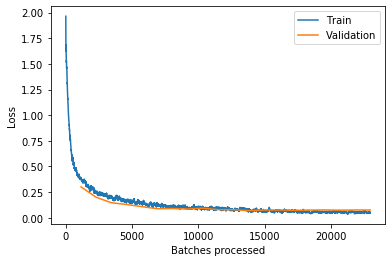

In [3]:
learn.recorder.plot_losses()

### Results (RestNet34 - No Tuned)

#### Confusion Matrix

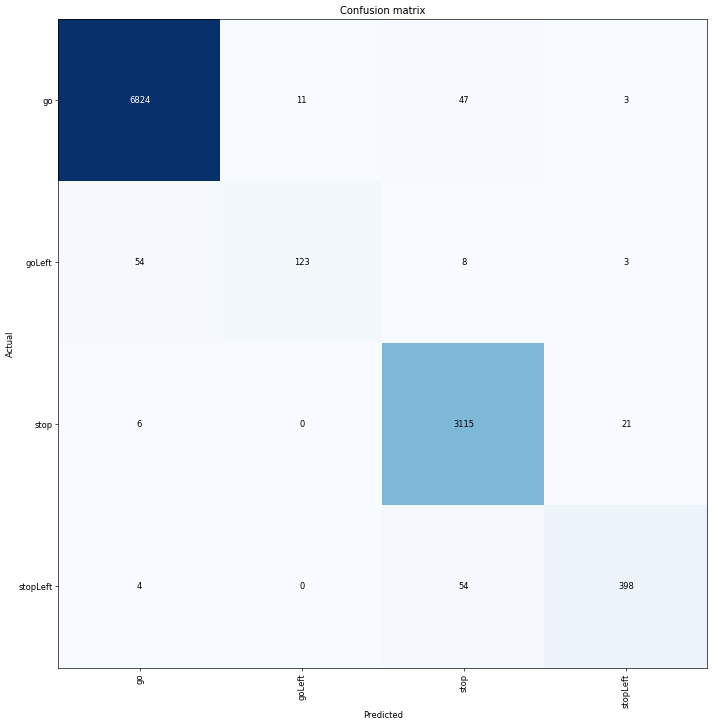

In [4]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
if len(data.valid_ds) == len(losses) == len(idxs):
    interp.plot_confusion_matrix(figsize = (12, 12), dpi = 60)

#### Most Confused Values

In [5]:
interp.most_confused(min_val = 1)

[('goLeft', 'go', 54),
 ('stopLeft', 'stop', 54),
 ('go', 'stop', 47),
 ('stop', 'stopLeft', 21),
 ('go', 'goLeft', 11),
 ('goLeft', 'stop', 8),
 ('stop', 'go', 6),
 ('stopLeft', 'go', 4),
 ('go', 'stopLeft', 3),
 ('goLeft', 'stopLeft', 3)]

#### Most Incorrect Samples

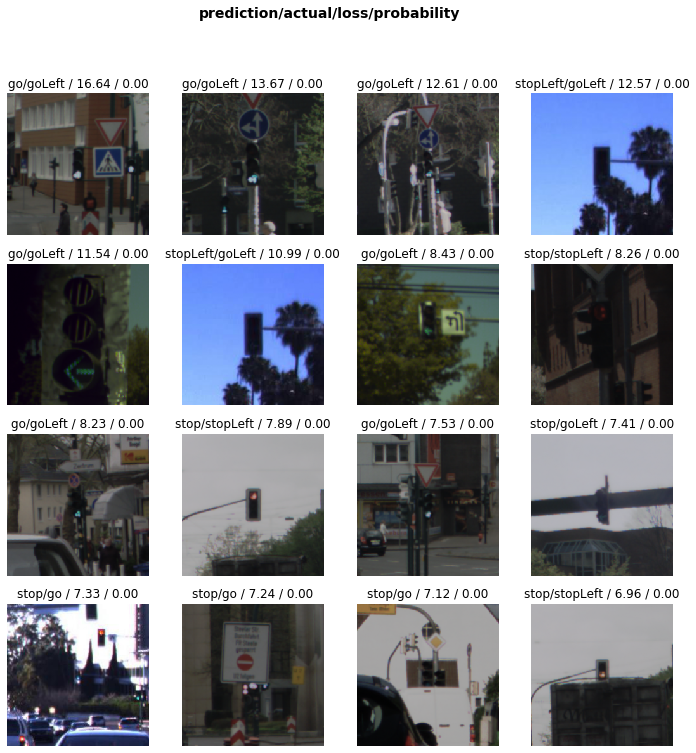

In [6]:
interp.plot_top_losses(16, heatmap=False)

#### Inference Time

In [7]:
get_inference_time(learn)

Inference test: ../data/test/21_warning.jpg
Results: (Category stop, tensor(2), tensor([0.0247, 0.0608, 0.8967, 0.0178]))

Inference test: ../data/test/07_go.png
Results: (Category go, tensor(0), tensor([9.9968e-01, 4.7948e-05, 2.3977e-04, 3.4455e-05]))

Inference test: ../data/test/10_go.jpg
Results: (Category go, tensor(0), tensor([9.9999e-01, 1.2614e-05, 1.5996e-06, 1.4265e-07]))

Inference test: ../data/test/12_stop.jpg
Results: (Category stop, tensor(2), tensor([7.7370e-10, 2.2658e-11, 1.0000e+00, 4.5380e-07]))

Inference test: ../data/test/19_stop.jpg
Results: (Category stop, tensor(2), tensor([2.2994e-02, 2.5490e-05, 9.7072e-01, 6.2626e-03]))

Inference test: ../data/test/24_stop.jpg
Results: (Category stop, tensor(2), tensor([2.5036e-02, 9.7201e-07, 9.7494e-01, 1.9863e-05]))

Inference test: ../data/test/06_stop.png
Results: (Category stop, tensor(2), tensor([4.6779e-04, 9.9388e-05, 9.4984e-01, 4.9595e-02]))

Inference test: ../data/test/20_stop.jpg
Results: (Category stop, ten

## Tuning ResNet34 Model

### Source Code

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


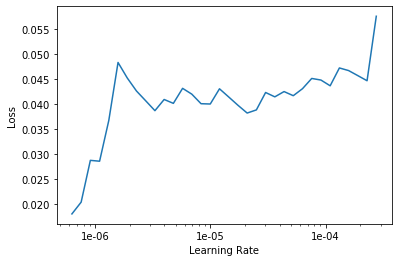

In [8]:
# Unfreeze first and last layers to tune
learn.unfreeze()

# Loading existing model
learn.load('resnet-34-no_tuning')

learn.lr_find()
learn.recorder.plot()

In [9]:
epochs = 20
min_range = 1e-5
max_range = 1e-4
max_lr = slice(min_range, max_range)
learn.fit_one_cycle(epochs, max_lr)

save_model(learn, 'resnet-34-tuned')

### Loss Graph

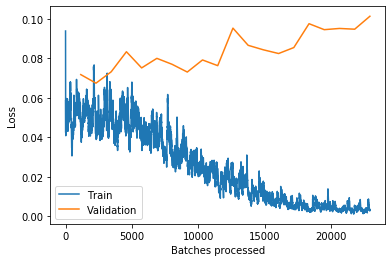

In [10]:
learn.recorder.plot_losses()

### Results

#### Confussion Matrix

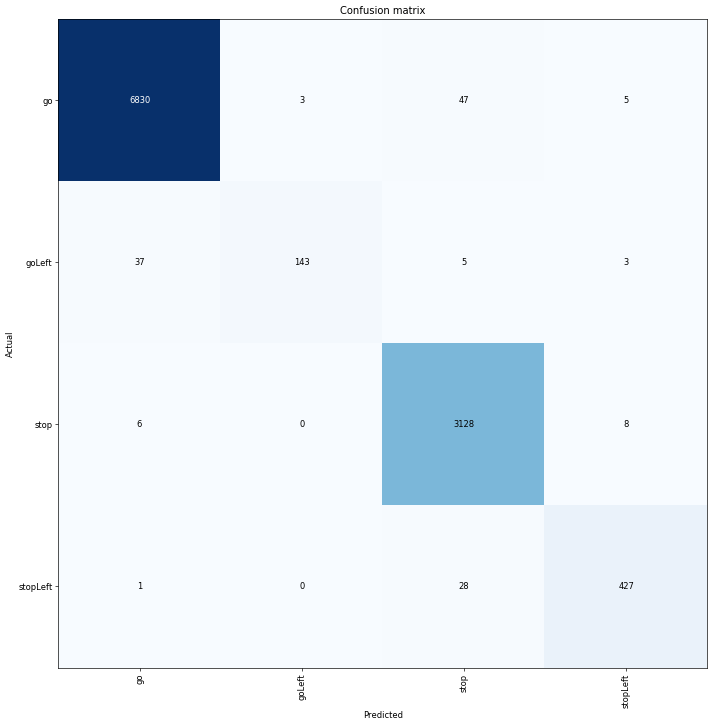

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
if len(data.valid_ds) == len(losses) == len(idxs):
    interp.plot_confusion_matrix(figsize = (12, 12), dpi = 60)

#### Most Confused Values

In [12]:
interp.most_confused()

[('go', 'stop', 47),
 ('goLeft', 'go', 37),
 ('stopLeft', 'stop', 28),
 ('stop', 'stopLeft', 8),
 ('stop', 'go', 6),
 ('go', 'stopLeft', 5),
 ('goLeft', 'stop', 5),
 ('go', 'goLeft', 3),
 ('goLeft', 'stopLeft', 3),
 ('stopLeft', 'go', 1)]

#### Most Incorrect Samples

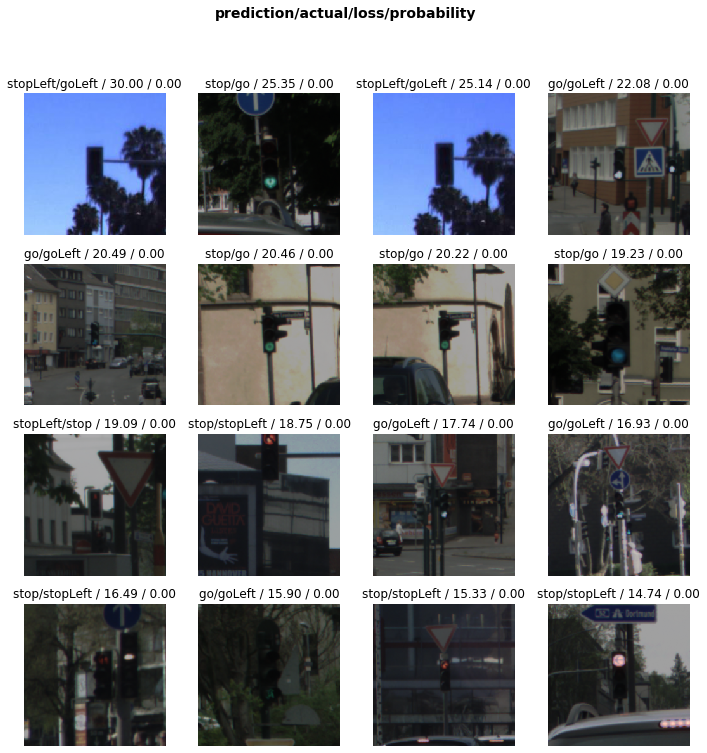

In [13]:
interp.plot_top_losses(16, heatmap = False)

#### Inference Time

In [14]:
get_inference_time(learn)

Inference test: ../data/test/21_warning.jpg
Results: (Category stop, tensor(2), tensor([1.4681e-06, 1.9446e-05, 9.8968e-01, 1.0300e-02]))

Inference test: ../data/test/07_go.png
Results: (Category go, tensor(0), tensor([9.9994e-01, 1.8833e-05, 3.8188e-05, 6.7794e-06]))

Inference test: ../data/test/10_go.jpg
Results: (Category go, tensor(0), tensor([1.0000e+00, 6.1325e-09, 3.3430e-09, 5.8830e-09]))

Inference test: ../data/test/12_stop.jpg
Results: (Category stop, tensor(2), tensor([2.0336e-08, 1.3021e-09, 1.0000e+00, 6.0151e-07]))

Inference test: ../data/test/19_stop.jpg
Results: (Category stop, tensor(2), tensor([4.5051e-03, 3.2753e-07, 9.9536e-01, 1.3620e-04]))

Inference test: ../data/test/24_stop.jpg
Results: (Category stop, tensor(2), tensor([2.1316e-02, 7.6561e-09, 9.7868e-01, 2.2054e-08]))

Inference test: ../data/test/06_stop.png
Results: (Category stop, tensor(2), tensor([1.7432e-04, 3.4959e-06, 9.9469e-01, 5.1330e-03]))

Inference test: ../data/test/20_stop.jpg
Results: (Ca

# CNN Classifier using ResNet50

## ResNet50 Model without Tuning

### Source Code

In [15]:
# Modification of batch size to fit GPU memory limitations
bs = 32

data = ImageDataBunch.from_folder(training_dataset_path
                                  , ds_tfms = get_transforms()
                                  , size = 224
                                  , bs = bs
                                 ).normalize(imagenet_stats)
learn = cnn_learner(data
                       , models.resnet50
                       , metrics = metrics
                       , callback_fns = PeakMemMetric
                      )

learn.fit_one_cycle(20)

save_model(learn, 'resnet-50-no_tuning')

### Loss Graph

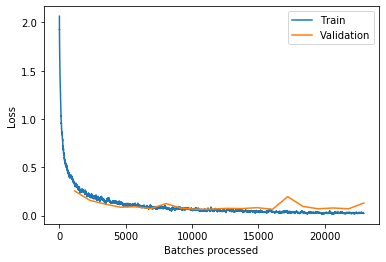

In [16]:
learn.recorder.plot_losses()

### Results (ResNet50)

#### Confusion Matrix

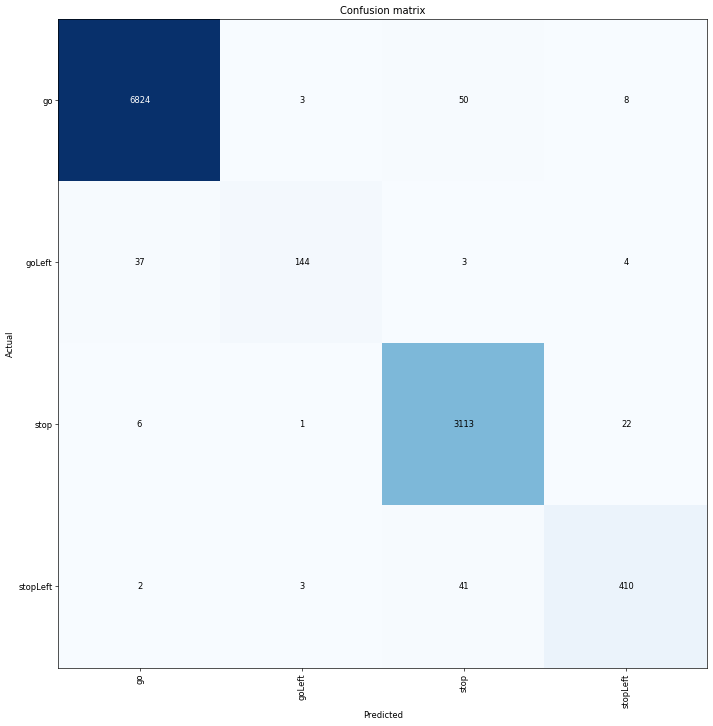

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize = (12, 12), dpi = 60)

#### Most Confused Values

In [18]:
interp.most_confused()

[('go', 'stop', 50),
 ('stopLeft', 'stop', 41),
 ('goLeft', 'go', 37),
 ('stop', 'stopLeft', 22),
 ('go', 'stopLeft', 8),
 ('stop', 'go', 6),
 ('goLeft', 'stopLeft', 4),
 ('go', 'goLeft', 3),
 ('goLeft', 'stop', 3),
 ('stopLeft', 'goLeft', 3),
 ('stopLeft', 'go', 2),
 ('stop', 'goLeft', 1)]

#### Most Incorrect Samples

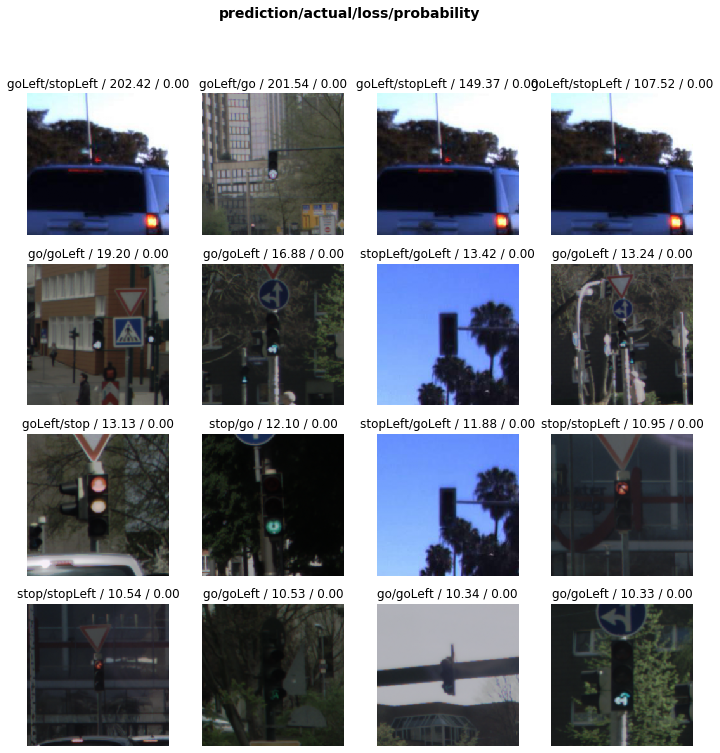

In [19]:
interp.plot_top_losses(16, heatmap = False)


#### Inference Time

In [21]:
get_inference_time(learn)

Inference test: ../data/test/21_warning.jpg
Results: (Category stop, tensor(2), tensor([2.0624e-02, 1.6871e-04, 9.7885e-01, 3.6223e-04]))

Inference test: ../data/test/07_go.png
Results: (Category go, tensor(0), tensor([9.9816e-01, 1.7365e-03, 1.0548e-05, 9.4073e-05]))

Inference test: ../data/test/10_go.jpg
Results: (Category go, tensor(0), tensor([9.9999e-01, 7.4519e-06, 6.7914e-06, 2.2114e-07]))

Inference test: ../data/test/12_stop.jpg
Results: (Category stop, tensor(2), tensor([2.5929e-05, 5.5911e-08, 9.9997e-01, 9.9098e-07]))

Inference test: ../data/test/19_stop.jpg
Results: (Category stop, tensor(2), tensor([0.1070, 0.0065, 0.8082, 0.0783]))

Inference test: ../data/test/24_stop.jpg
Results: (Category stop, tensor(2), tensor([6.5279e-04, 5.5029e-09, 9.9935e-01, 2.3023e-07]))

Inference test: ../data/test/06_stop.png
Results: (Category stop, tensor(2), tensor([2.1454e-03, 7.8626e-05, 9.9632e-01, 1.4563e-03]))

Inference test: ../data/test/20_stop.jpg
Results: (Category stop, ten

## Tuning ResNet50 Model

### Source Code

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


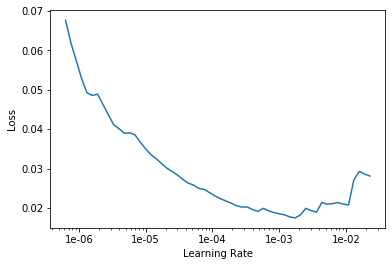

In [25]:
learn.load('resnet-50-no_tuning')

learn.lr_find()
learn.recorder.plot()

In [26]:
epochs = 20
min_range = 1e-5
max_range = 1e-3
max_lr = slice(min_range, max_range)
learn.fit_one_cycle(epochs, max_lr)

save_model(learn, 'resnet-50-tuned')

### Loss Graph

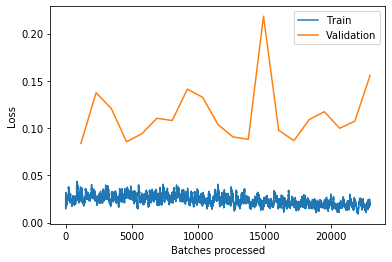

In [27]:
learn.recorder.plot_losses()

### Results (ResNet 50 Tuned)

#### Confusion Matrix

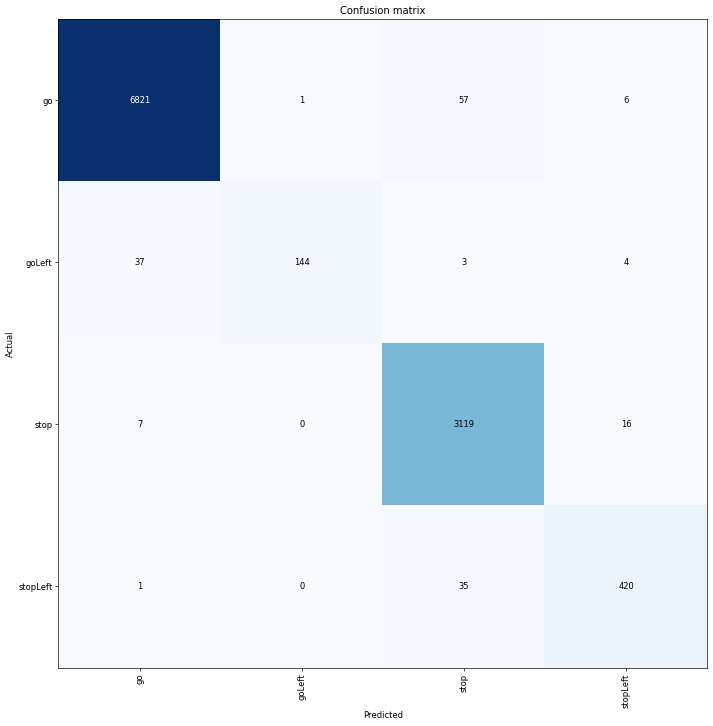

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize = (12, 12), dpi = 60)

#### Most Confused Values

In [29]:
interp.most_confused()

[('go', 'stop', 57),
 ('goLeft', 'go', 37),
 ('stopLeft', 'stop', 35),
 ('stop', 'stopLeft', 16),
 ('stop', 'go', 7),
 ('go', 'stopLeft', 6),
 ('goLeft', 'stopLeft', 4),
 ('goLeft', 'stop', 3),
 ('go', 'goLeft', 1),
 ('stopLeft', 'go', 1)]

#### Most Incorrect Samples

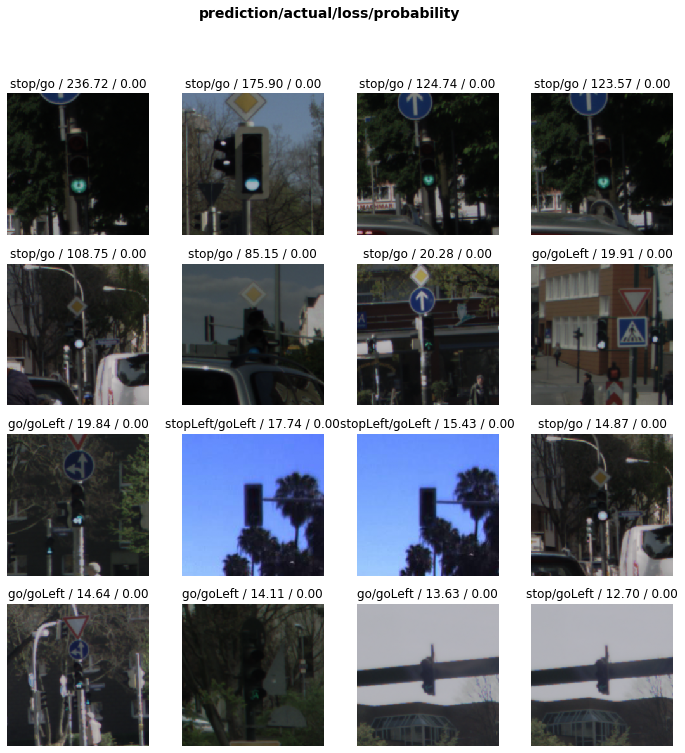

In [30]:
interp.plot_top_losses(16, heatmap = False)

#### Inference Time

In [32]:
get_inference_time(learn)

Inference test: ../data/test/21_warning.jpg
Results: (Category stop, tensor(2), tensor([3.1557e-03, 2.1834e-05, 9.8927e-01, 7.5500e-03]))

Inference test: ../data/test/07_go.png
Results: (Category go, tensor(0), tensor([9.9997e-01, 2.5385e-05, 1.0361e-06, 3.7999e-06]))

Inference test: ../data/test/10_go.jpg
Results: (Category go, tensor(0), tensor([9.9999e-01, 4.2293e-07, 5.8025e-06, 3.1986e-08]))

Inference test: ../data/test/12_stop.jpg
Results: (Category stop, tensor(2), tensor([1.0075e-05, 1.1321e-07, 9.9999e-01, 8.6368e-07]))

Inference test: ../data/test/19_stop.jpg
Results: (Category stop, tensor(2), tensor([1.4259e-01, 5.0053e-04, 8.4617e-01, 1.0735e-02]))

Inference test: ../data/test/24_stop.jpg
Results: (Category stop, tensor(2), tensor([3.2120e-05, 4.6628e-16, 9.9997e-01, 6.8006e-11]))

Inference test: ../data/test/06_stop.png
Results: (Category stop, tensor(2), tensor([1.2290e-03, 1.7055e-05, 9.9804e-01, 7.1629e-04]))

Inference test: ../data/test/20_stop.jpg
Results: (Ca

# CNN Classifier using DenseNet121

### Source Code

In [33]:
bs = 32

data = ImageDataBunch.from_folder(training_dataset_path
                                  , ds_tfms = get_transforms()
                                  , size = 224
                                  , bs = bs
                                 ).normalize(imagenet_stats)
learn = cnn_learner(data
                       , models.densenet121
                       , metrics = metrics
                       , callback_fns = PeakMemMetric
                      )
learn.fit_one_cycle(20)

save_model(learn, 'densenet-121-no_tuning')

### Loss Graph

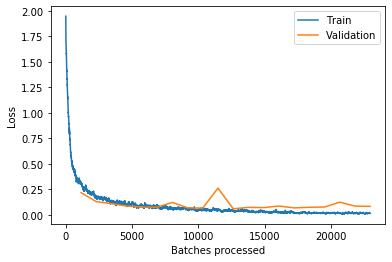

In [34]:
learn.recorder.plot_losses()

### Results (DenseNet 121)

#### Confusion Matrix

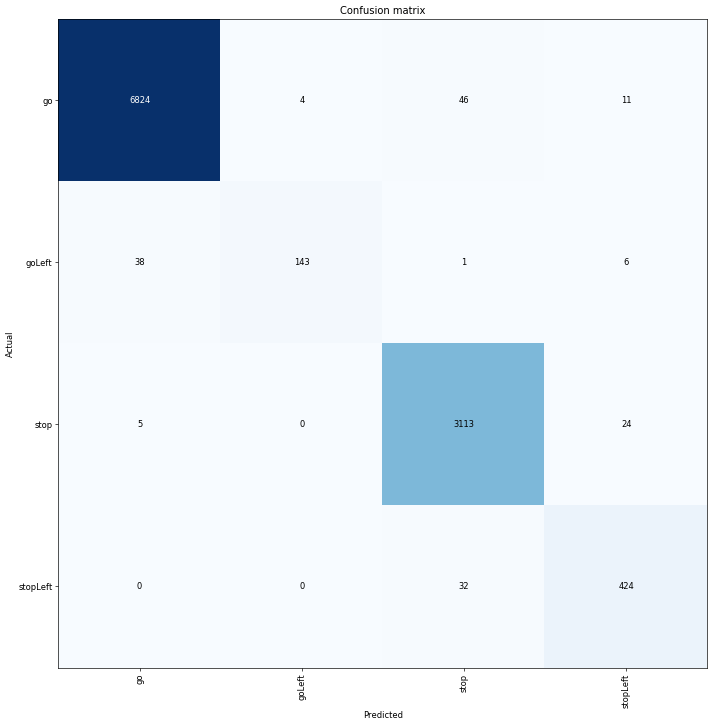

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize = (12, 12), dpi = 60)

#### Most Confused Values

In [36]:
interp.most_confused()

[('go', 'stop', 46),
 ('goLeft', 'go', 38),
 ('stopLeft', 'stop', 32),
 ('stop', 'stopLeft', 24),
 ('go', 'stopLeft', 11),
 ('goLeft', 'stopLeft', 6),
 ('stop', 'go', 5),
 ('go', 'goLeft', 4),
 ('goLeft', 'stop', 1)]

#### Most Incorrect Samples

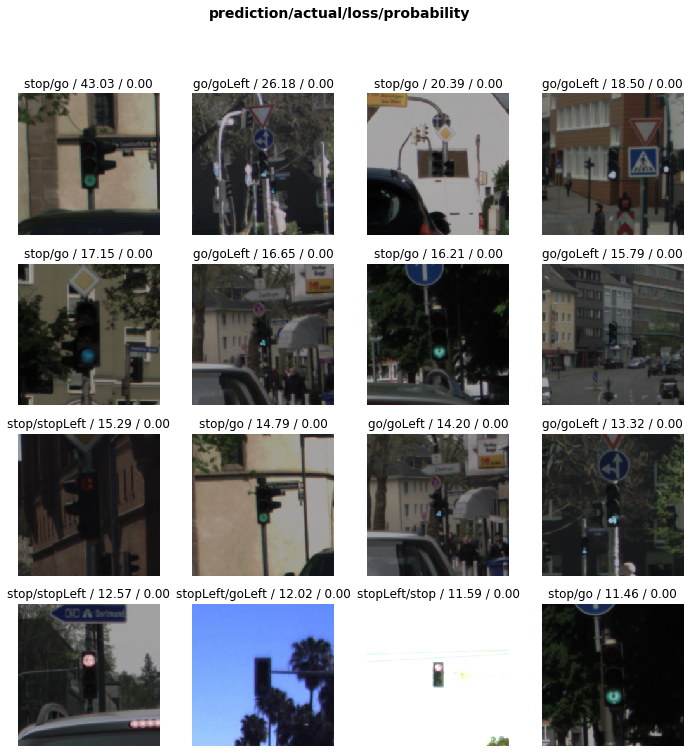

In [37]:
interp.plot_top_losses(16, heatmap = False)

#### Inference Time

In [40]:
get_inference_time(learn)

Inference test: ../data/test/21_warning.jpg
Results: (Category stop, tensor(2), tensor([6.9728e-06, 4.5668e-04, 9.9950e-01, 3.9955e-05]))

Inference test: ../data/test/07_go.png
Results: (Category go, tensor(0), tensor([9.9069e-01, 2.3886e-04, 1.6979e-03, 7.3710e-03]))

Inference test: ../data/test/10_go.jpg
Results: (Category go, tensor(0), tensor([1.0000e+00, 3.1022e-08, 9.1545e-09, 1.6268e-08]))

Inference test: ../data/test/12_stop.jpg
Results: (Category stop, tensor(2), tensor([8.8792e-07, 2.1012e-08, 1.0000e+00, 6.7899e-08]))

Inference test: ../data/test/19_stop.jpg
Results: (Category stop, tensor(2), tensor([2.8963e-02, 3.9784e-04, 7.8076e-01, 1.8988e-01]))

Inference test: ../data/test/24_stop.jpg
Results: (Category stop, tensor(2), tensor([0.0013, 0.0032, 0.9919, 0.0037]))

Inference test: ../data/test/06_stop.png
Results: (Category stop, tensor(2), tensor([2.4878e-05, 6.7370e-07, 9.9967e-01, 3.0537e-04]))

Inference test: ../data/test/20_stop.jpg
Results: (Category stop, ten

## Tuning DenseNet121 Model

### Source Code

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


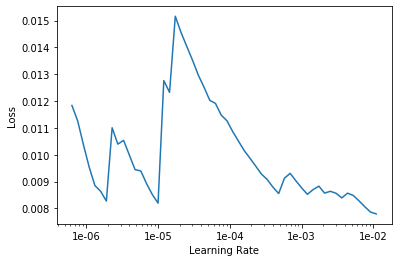

In [42]:
learn.load('densenet-121-no_tuning')
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.unfreeze()

epochs = 20
min_range = 1e-3
max_range = 1e-2
max_lr = slice(min_range, max_range)
learn.fit_one_cycle(epochs, max_lr)

save_model(learn, 'densenet-121-tuned')

### Loss Graph

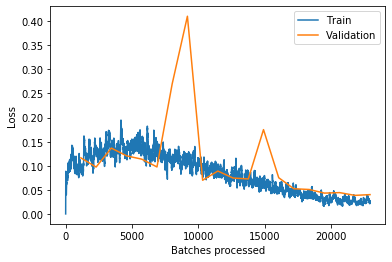

In [44]:
learn.recorder.plot_losses()

### Results

#### Confussion Matrix

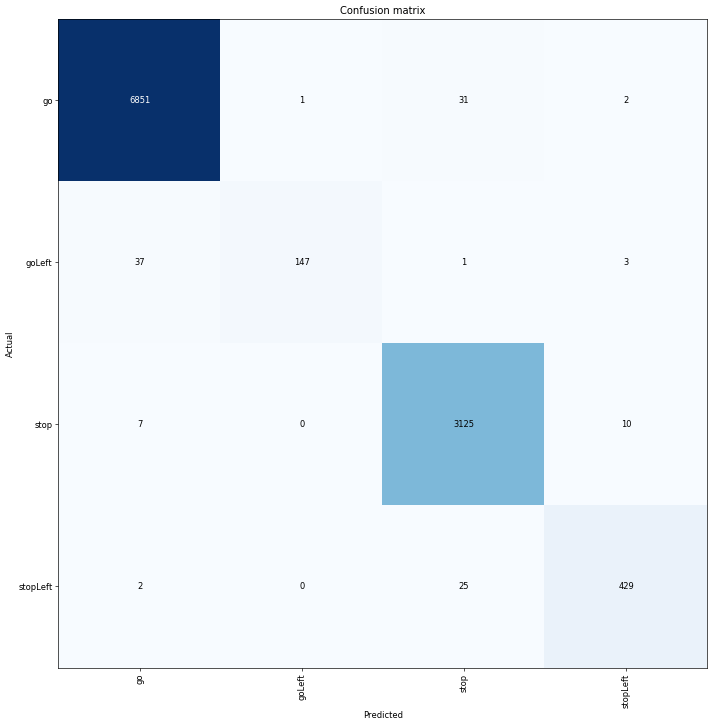

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize = (12, 12), dpi = 60)

#### Most Confused Values

In [46]:
interp.most_confused()

[('goLeft', 'go', 37),
 ('go', 'stop', 31),
 ('stopLeft', 'stop', 25),
 ('stop', 'stopLeft', 10),
 ('stop', 'go', 7),
 ('goLeft', 'stopLeft', 3),
 ('go', 'stopLeft', 2),
 ('stopLeft', 'go', 2),
 ('go', 'goLeft', 1),
 ('goLeft', 'stop', 1)]

#### Most Incorrect Samples

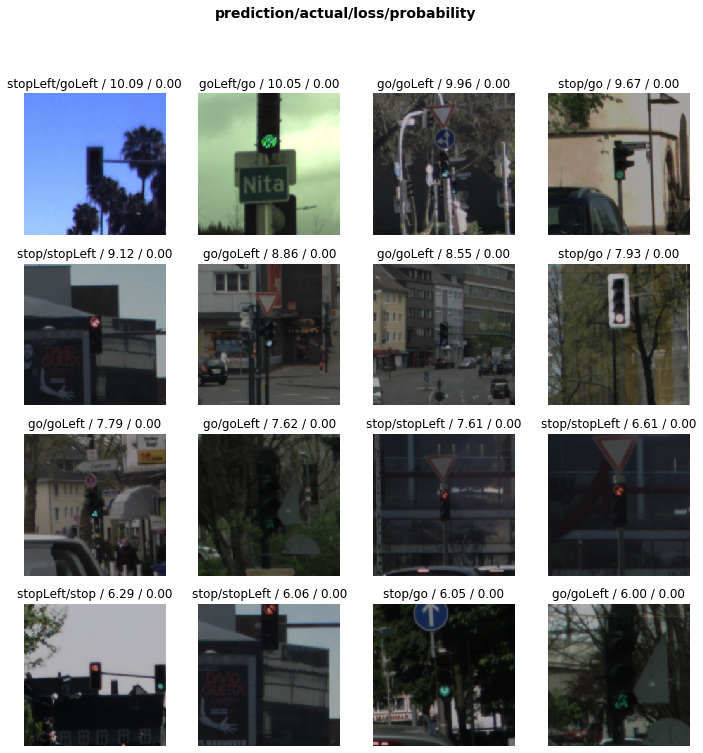

In [47]:
interp.plot_top_losses(16, heatmap = False)

#### Inference Time

In [50]:
get_inference_time(learn)

Inference test: ../data/test/21_warning.jpg
Results: (Category go, tensor(0), tensor([9.8503e-01, 3.9334e-04, 1.4388e-02, 1.9222e-04]))

Inference test: ../data/test/07_go.png
Results: (Category go, tensor(0), tensor([9.9883e-01, 1.5268e-05, 1.0372e-03, 1.1517e-04]))

Inference test: ../data/test/10_go.jpg
Results: (Category go, tensor(0), tensor([1.0000e+00, 1.0416e-08, 2.2787e-08, 2.4122e-07]))

Inference test: ../data/test/12_stop.jpg
Results: (Category stop, tensor(2), tensor([7.7727e-06, 2.8842e-06, 9.9996e-01, 3.1265e-05]))

Inference test: ../data/test/19_stop.jpg
Results: (Category stop, tensor(2), tensor([3.8179e-04, 1.3629e-05, 9.7915e-01, 2.0452e-02]))

Inference test: ../data/test/24_stop.jpg
Results: (Category stop, tensor(2), tensor([1.1992e-03, 8.2305e-06, 9.9690e-01, 1.8912e-03]))

Inference test: ../data/test/06_stop.png
Results: (Category stop, tensor(2), tensor([2.2161e-06, 6.9972e-07, 9.9978e-01, 2.1605e-04]))

Inference test: ../data/test/20_stop.jpg
Results: (Cate